「RとStanで始めるベイズ統計モデリングによるデータ分析入門 実践編第8章 ポアソン回帰モデル」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備

## パッケージの読み込み

In [1]:
import os
import arviz
import pystan
import pickle
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# データの読み込みと図示

## 分析対象のデータ

In [2]:
fish_num_climate = pd.read_csv('3-8-1-fish-num-1.csv')
fish_num_climate.head(n=3)

,fish_num,weather,temperature
0,0,cloudy,5.5
1,2,cloudy,21.1
2,5,cloudy,17.2


## データの要約

In [3]:
fish_num_climate.describe(include='all')

,fish_num,weather,temperature
count,100.000000,100,100.000000
unique,NaN,2,NaN
top,NaN,cloudy,NaN
freq,NaN,50,NaN
mean,1.600000,NaN,14.747000
std,1.933229,NaN,8.956826
min,0.000000,NaN,0.200000
25%,0.000000,NaN,6.750000
50%,1.000000,NaN,13.250000
75%,2.000000,NaN,23.225000


## 図示

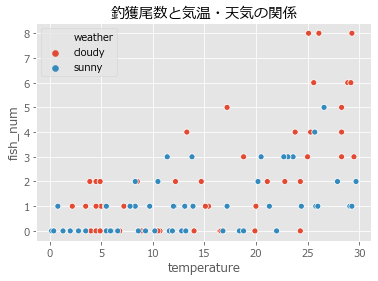

In [4]:
plt.figure()
sns.scatterplot(x='temperature', y='fish_num', data=fish_num_climate, hue='weather')
plt.title('釣獲尾数と気温・天気の関係')
plt.show()

# brmsによる分散分析モデルの推定

pythonにbrmsの代用可能なパッケージが知っている範囲内で存在しないため，brmsを利用したコードは省略しています。

# 補足：brmsを用いない実装の方法

## 参考：デザイン行列の作成

In [8]:
# 応答変数の削除とダミー変数化処理
design_mat = pd.get_dummies(fish_num_climate.drop(['fish_num'], axis=1),
                   drop_first=True)

# 列名を書籍準拠に
design_mat = design_mat[['weather_sunny', 'temperature']]

# (Intercept)列追加
design_mat.insert(0, '(Intercept)', 1)

display(design_mat)

,(Intercept),weather_sunny,temperature
0,1,0,5.5
1,1,0,21.1
2,1,0,17.2
3,1,0,5.0
4,1,0,28.3
...,...,...,...
95,1,1,5.9
96,1,1,12.8
97,1,1,2.8
98,1,1,3.5


## 参考：データの作成

In [10]:
data_list_1 = dict(N=len(fish_num_climate),
                   fish_num=fish_num_climate['fish_num'],
                   temp=fish_num_climate['temperature'],
                   sunny=design_mat['weather_sunny'])

display(data_list_1)

{'N': 100,
 'fish_num': 0     0
 1     2
 2     5
 3     1
 4     3
      ..
 95    0
 96    0
 97    0
 98    0
 99    0
 Name: fish_num, Length: 100, dtype: int64,
 'temp': 0      5.5
 1     21.1
 2     17.2
 3      5.0
 4     28.3
       ... 
 95     5.9
 96    12.8
 97     2.8
 98     3.5
 99    13.2
 Name: temperature, Length: 100, dtype: float64,
 'sunny': 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 95    1
 96    1
 97    1
 98    1
 99    1
 Name: weather_sunny, Length: 100, dtype: uint8}

## 参考：自分で変換処理を入れる

In [11]:
# stanコードの記述
stan_code = '''
data {
  int N;                   // サンプルサイズ
  int fish_num[N];         // 釣獲尾数
  vector[N] temp;          // 気温データ
  vector[N] sunny;         // 晴れダミー変数
}

parameters {
  real Intercept;      // 切片
  real b_temp;         // 係数(気温)
  real b_sunny;        // 係数(晴れの影響)
}

model {
  vector[N] lambda = exp(Intercept + b_temp*temp + b_sunny*sunny);
  fish_num ~ poisson(lambda);
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
glm_pois_stan_exp = stan_model.sampling(data=data_list_1, seed=2, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_10b93b39bc827a53de74eb5431c131b8 NOW.


## 結果の表示

In [12]:
print(glm_pois_stan_exp.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_10b93b39bc827a53de74eb5431c131b8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept  -0.79  6.0e-3   0.24   -1.3  -0.79  -0.35   1628    1.0
b_temp      0.08  2.4e-4   0.01   0.06   0.08    0.1   1682    1.0
b_sunny    -0.59  3.7e-3   0.17  -0.93  -0.59  -0.26   2089    1.0
lp__      -37.73    0.03   1.22 -40.95 -37.41 -36.32   1412    1.0

Samples were drawn using NUTS at Sun Aug 30 15:53:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：poisson_log関数を使用

In [13]:
# stanコードの記述
stan_code = '''
data {
  int N;                   // サンプルサイズ
  int fish_num[N];         // 釣獲尾数
  vector[N] temp;          // 気温データ
  vector[N] sunny;         // 晴れダミー変数
}

parameters {
  real Intercept;      // 切片
  real b_temp;         // 係数(気温)
  real b_sunny;        // 係数(晴れの影響)
}

model {
  vector[N] lambda = Intercept + b_temp*temp + b_sunny*sunny;
  fish_num ~ poisson_log(lambda);
}

generated quantities {
    vector[N] lambda_sunny;
    vector[N] lambda_cloudy;
    vector[N] fish_num_sunny;
    vector[N] fish_num_cloudy;
    
    for(i in 1:N){
        lambda_sunny[i] = Intercept +  b_temp*temp[i] + b_sunny*1;
        lambda_cloudy[i] = Intercept +  b_temp*temp[i] + b_sunny*0;
        fish_num_sunny[i] = poisson_log_rng(lambda_sunny[i]);
        fish_num_cloudy[i] = poisson_log_rng(lambda_cloudy[i]);
    }
}
'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
glm_pois_stan = stan_model.sampling(data=data_list_1, seed=2, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d78a2071bf51cbe1e42c5c01664ea40 NOW.


RuntimeError: Exception: poisson_log_rng: Log rate parameter is 39.0788, but must be less than 20.7944  (in 'unknown file name' at line 29)


## 参考：結果の表示

In [ ]:
print(glm_pois_stan.stansummary(probs=[0.025, 0.5, 0.975]))

In [14]:
# stanコードの記述
stan_code = '''
data {
  int N;                   // サンプルサイズ
  int fish_num[N];         // 釣獲尾数
  vector[N] temp;          // 気温データ
  vector[N] sunny;         // 晴れダミー変数
}

parameters {
  real Intercept;      // 切片
  real b_temp;         // 係数(気温)
  real b_sunny;        // 係数(晴れの影響)
}

model {
  vector[N] lambda = Intercept + b_temp*temp + b_sunny*sunny;
  fish_num ~ poisson_log(lambda);
}

generated quantities {
    vector[N] lambda_sunny;
    vector[N] lambda_cloudy;
    
    for(i in 1:N){
        lambda_sunny[i] = Intercept +  b_temp*temp[i] + b_sunny*1;
        lambda_cloudy[i] = Intercept +  b_temp*temp[i] + b_sunny*0;
    }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

data_list_1 = dict(N=len(fish_num_climate),
                   fish_num=fish_num_climate['fish_num'],
                   temp=fish_num_climate['temperature'],
                   sunny=design_mat['weather_sunny'])

# サンプリング
glm_pois_stan_exp = stan_model.sampling(data=data_list_1, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9c7a0c6958592662ed045a85b104473 NOW.


In [29]:
print(glm_pois_stan_exp.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_a89f5c970af381714b5d2bc1507c0509.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%     50%   97.5%  n_eff   Rhat
Intercept             -0.79  5.8e-3   0.24  -1.26   -0.79   -0.34   1651    1.0
b_temp                 0.08  2.4e-4 9.9e-3   0.06    0.08     0.1   1730    1.0
b_sunny                -0.6  3.9e-3   0.17  -0.94   -0.59   -0.29   1819    1.0
lambda_sunny[1]       -0.93  4.6e-3    0.2  -1.34   -0.93   -0.53   2021    1.0
lambda_sunny[2]        0.36  3.0e-3   0.14   0.08    0.37    0.62   2165    1.0
lambda_sunny[3]        0.04  2.9e-3   0.14  -0.26    0.04     0.3   2400    1.0
lambda_sunny[4]       -0.98  4.6e-3   0.21  -1.39   -0.98   -0.57   2010    1.0
lambda_sunny[5]        0.96  3.5e-3   0.16   0.63    0.96    1.26   2024    1.0
lambda_sunny[6]        0.96  3.5e-3   0.16   0.63    0.96    1.26   2024    1.0
lambda_sunn

# 補足：デザイン行列を使ったモデルの推定

## 参考：Stanに渡すデータ

In [ ]:
data_list_2 = dict(N=len(fish_num_climate),
                   K=design_mat.shape[1],
                   Y=fish_num_climate['fish_num'],
                   X=design_mat)

display(data_list_2)

In [ ]:
## 参考：MCMCの実行

In [ ]:
# stanコードの記述
stan_code = '''
data { 
  int N;                // サンプルサイズ
  int K;                // デザイン行列の列数(説明変数の数＋１)
  int Y[N];             // 応答変数(整数型)
  matrix[N, K] X;       // デザイン行列 
} 

parameters { 
  vector[K] b;          // 切片を含む係数ベクトル
} 

model { 
  vector[N] lambda = X * b;
  Y ~ poisson_log(lambda);
} 

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
glm_pois_stan_design_mat = stan_model.sampling(data=data_list_2, seed=1, n_jobs=1)

In [ ]:
## 参考：結果の表示

In [ ]:
print(glm_pois_stan_design_mat.stansummary(probs=[0.025, 0.5, 0.975]))